In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import lmfit
from pytz import timezone
import vaex
import pvlib

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show  # noqa: E402

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'

def input_output_response_to_pandas(response: ct.input_output_response):
    # until this gets merged: https://github.com/python-control/python-control/issues/957
    data = {'time': response.time}
    if response.ninputs > 0:
        data.update(
            {name: response.inputs[i] for i, name in enumerate(response.input_labels)})
    if response.noutputs > 0:
        data.update(
            {name: response.outputs[i] for i, name in enumerate(response.output_labels)})
    if response.nstates > 0:
        data.update(
            {name: response.states[i] for i, name in enumerate(response.state_labels)})
    return pd.DataFrame(data)

# Parameters

In [99]:
propulsion_params = {
    'motor_R': 0.033757265716427315,
    'motor_L': 0.0010492267299141082,
    'motor_B': 0.003901852250197858,
    'motor_J': 0.039200000000000006,
    'motor_J_load': 7.740892852532529e-05,
    'motor_K': 0.10324265711774457,
    'prop_K': 0.0016398967597139407,
    'prop_D': 0.20511514437186884,
    'rho': 1025,
    'trans_eff': 0.95,
    'esc_eff': 0.8,
    'trans_K': 0.5909090909090909,
}
generation_params = {
    'pv_area': 1.650 * 0.992,
    'pv_eff': 0.1589,
    'mppt_eff': 0.9303414194668972,
    'mppt_n': 4,
}
battery_params = { # From: modelling_battery_nonlinear-sprint-dataset.ipynb
    'bat_eff': 1,
    'bat_Q': 38 * 3600 * 1E6, # MULTIPLIED BY 1E6 TO DISCARD THE EFFECT OF SOC
    'bat_R_0': 0.07688995265604726,
    'bat_R_1': 0.007914593252093682,
    'bat_C_1': 22.97248164632932,
    'bat_coeffs': [25.4633167882052, 37.126691660372906, -21.115645449324788, -30.02431761749073, 29.382700604694268],
}
solar_boat_params = generation_params | battery_params | propulsion_params

# Solar Boat System model

In [100]:
import control as ct

class SolarBoat:
    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Parameters
        bat_R1, bat_C1, bat_Q, bat_eff, motor_K, motor_R, motor_L, motor_J, motor_B, motor_J_load = (
            params['bat_R_1'],  # battery internal serie-parallel resistance [Ohms]
            params['bat_C_1'],  # battery internal serie-parallel capacitance [Ohms]
            params['bat_Q'],  # battery Capacity [Ah]
            params['bat_eff'],  # battery efficency [unitless]
            params['motor_K'],  # Motor torque constant [Nm/A]
            params['motor_R'],  # Motor internal resistance [Ohms]
            params['motor_L'],  # Motor internal inductance [H]
            params['motor_J'],  # Motor inertia [kg m^2]
            params['motor_B'],  # Motor viscous friction coefficient [Nm/(rad/s)]
            params['motor_J_load'],  # Motor load inertia [kg m^2]
        )

        # States
        bat_i_R1 = x[0]  # battery current flowing through the internal serie-parallel resistance [A]
        motor_i = x[2]  # Motor current [A]
        motor_w = x[3]  # Motor angular speed [rad/s]

        # Outputs
        y = cls._outputs(t, x, u, params)
        bat_i = y[2]
        motor_w = y[5]
        motor_v = y[6]
        motor_load_q = y[7]

        # System of differential equations
        bat_di_R1_dt = (-bat_i_R1 + bat_i) * (1 / (bat_R1 * bat_C1))
        bat_dSOC_dt = -bat_eff * bat_i / bat_Q
        motor_didt = (-(motor_R * motor_i) - (motor_K * motor_w) + motor_v) / motor_L
        motor_dwdt = (+(motor_K * motor_i) - (motor_B * motor_w) - motor_load_q) / (motor_J + motor_J_load)

        return bat_di_R1_dt, bat_dSOC_dt, motor_didt, motor_dwdt

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Parameters
        pv_eff, pv_area, mppt_eff, mppt_n, bat_R0, bat_R1, bat_coeffs, prop_K, prop_D, rho, trans_eff, trans_K, esc_eff = (
            params['pv_eff'],  # Photovoltaic Panel average efficiency [unitless]
            params['pv_area'],  # Photovoltaic Panel total area [m^2]
            params['mppt_eff'],  # MPPT efficiency [unitless]
            params['mppt_n'],  # Number of solar panels + mppt arrays
            params['bat_R_0'],  # battery internal series resistance [Ohms]
            params['bat_R_1'],  # battery internal serie-parallel resistance [Ohms]
            params['bat_coeffs'],  # battery OCV(SOC) polynomial coefficients [V]
            params['prop_K'],  # Propeller constant [Nm / (kg m^2 (rad / s)^2)]
            params['prop_D'],  # Propeller diameter [m]
            params['rho'],  # Water density [kg/m^3]
            params['trans_eff'],  # Transmission efficiency [unitless]
            params['trans_K'],  # Transmission gear ratio as `output speed / input speed` [unitless]
            params['esc_eff'],  # ESC efficiency [unitless]
        )

        # Inputs
        G = u[0]  # Total incident irradiance [W/m^2]
        esc_d = u[1]  # ESC duty-cycle

        # States
        bat_i_R1 = x[0]  # battery current flowing through the internal serie-parallel resistance [A]
        bat_SOC = x[1]  # battery State Of Charge [unitless]
        motor_i = x[2]  # Motor current [A]
        motor_w = x[3]  # Motor angular speed [rad/s]

        # Simplified Photovoltaic Panel + MPPT
        mppt_po = G * pv_area * pv_eff * mppt_eff * mppt_n

        # ESC
        esc_d = np.clip(esc_d, 0, 1)
        esc_ii = motor_i * esc_d / esc_eff

        # battery
        bat_OCV = np.polynomial.Polynomial(bat_coeffs)(bat_SOC)
        # The following three equations could be solved for (bat_i, bat_v) simultaneously:
        #       mppt_io = (mppt_po / bat_v) if bat_v > 0 else 0
        #       bat_i = esc_ii - mppt_io
        #       bat_v = -bat_R1 * bat_i_R1 -bat_R0 * bat_i + bat_OCV
        # But for simplicity, they were combined into the following single equation:
        #       bat_v = -bat_R1 * bat_i_R1 -bat_R0 * (esc_ii - ((mppt_po / bat_v))) + bat_OCV
        # Then, if we solve it for bat_v, we get:
        bat_v = (-(bat_R1 * bat_i_R1) - (bat_R0 * esc_ii) + bat_OCV + np.sqrt((bat_R1**2 * bat_i_R1**2) + (2 * bat_R1 * bat_i_R1 * bat_R0 * esc_ii) + (bat_R0**2 * esc_ii**2) + (4 * bat_R0 * mppt_po) - (2 * bat_R1 * bat_i_R1 * bat_OCV) - (2 * bat_R0 * esc_ii * bat_OCV) + bat_OCV**2)) / 2

        # ESC
        motor_v = esc_d * bat_v

        # # MPPT
        mppt_io = mppt_po / bat_v if bat_v != 0 else 0

        # # battery current node
        bat_i = esc_ii - mppt_io

        # # Propeller
        prop_w = motor_w * trans_K
        prop_q = (prop_D ** 5) * rho * prop_K * (prop_w ** 2)
        motor_load_q = prop_q * trans_K / trans_eff

        return bat_v, bat_SOC, bat_i, mppt_io, esc_ii, motor_w, motor_v, motor_load_q


    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='boat',
            states=('bat_i_R1', 'bat_SOC', 'motor_i', 'motor_w'),
            inputs=('G', 'D'),
            outputs=('bat_v', 'bat_SOC', 'bat_i', 'bat_ii', 'esc_ii', 'motor_w', 'motor_v', 'motor_q'),
            params=params,
        )

In [101]:
SolarBoat.build(solar_boat_params)

<NonlinearIOSystem:boat:['G', 'D']->['bat_v', 'bat_SOC', 'bat_i', 'bat_ii', 'esc_ii', 'motor_w', 'motor_v', 'motor_q']>

# Example of comparing a change in the transmission system, using the same propeller


In [102]:
from datetime import timedelta, datetime
import itertools
import numpy as np
import pandas as pd


initial_SOC = 1

start_date = datetime(year=2024, month=6, day=16, hour=10)
race_duration = timedelta(minutes=1)
timestamp = pd.date_range(start=start_date, end=start_date + race_duration, freq='s')

irradiation = 0
solar_poa = np.ones(timestamp.shape) * irradiation

esc_d = np.linspace(0, 1, timestamp.size)

df = pd.DataFrame(dict(timestamp=timestamp, solar_poa=solar_poa, esc_d=esc_d)).set_index('timestamp')
df


,solar_poa,esc_d
timestamp,,
2024-06-16 10:00:00,0.0,0.000000
2024-06-16 10:00:01,0.0,0.016667
2024-06-16 10:00:02,0.0,0.033333
2024-06-16 10:00:03,0.0,0.050000
2024-06-16 10:00:04,0.0,0.066667
...,...,...
2024-06-16 10:00:56,0.0,0.933333
2024-06-16 10:00:57,0.0,0.950000
2024-06-16 10:00:58,0.0,0.966667


In [103]:
# Input data
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)

U = df[['solar_poa', 'esc_d']].copy(deep=True).to_numpy().T

solar_boat = SolarBoat.build(solar_boat_params)
X0 = np.zeros(solar_boat.nstates)
X0[solar_boat.state_index['bat_SOC']] = initial_SOC

solar_boat_params_1 = solar_boat_params.copy()
solar_boat_params_1['trans_K'] = 13/22
results_transmission_1 = ct.input_output_response(
    SolarBoat.build(params=solar_boat_params_1),
    T=T,
    U=U,
    X0=X0,
    solve_ivp_method='Radau',
).to_pandas().set_index('time')

solar_boat_params_2 = solar_boat_params.copy()
solar_boat_params_2['trans_K'] = 1
results_transmission_2 = ct.input_output_response(
    SolarBoat.build(params=solar_boat_params_2),
    T=T,
    U=U,
    X0=X0,
    solve_ivp_method='Radau',
).to_pandas().set_index('time')

solar_boat_params_3 = solar_boat_params.copy()
solar_boat_params_3['trans_K'] = 1/2
results_transmission_3 = ct.input_output_response(
    SolarBoat.build(params=solar_boat_params_3),
    T=T,
    U=U,
    X0=X0,
    solve_ivp_method='Radau',
).to_pandas().set_index('time')

In [104]:
results_transmission_1['bat_p'] = results_transmission_1['bat_i'] * results_transmission_1['bat_v']
results_transmission_2['bat_p'] = results_transmission_2['bat_i'] * results_transmission_2['bat_v']
results_transmission_3['bat_p'] = results_transmission_3['bat_i'] * results_transmission_3['bat_v']

results_transmission_1['motor_pi'] = results_transmission_1['motor_v'] * results_transmission_1['motor_i']
results_transmission_2['motor_pi'] = results_transmission_2['motor_v'] * results_transmission_2['motor_i']
results_transmission_3['motor_pi'] = results_transmission_3['motor_v'] * results_transmission_3['motor_i']
results_transmission_1['motor_po'] = results_transmission_1['motor_w'] * results_transmission_1['motor_q']
results_transmission_2['motor_po'] = results_transmission_2['motor_w'] * results_transmission_2['motor_q']
results_transmission_3['motor_po'] = results_transmission_3['motor_w'] * results_transmission_3['motor_q']
results_transmission_1['motor_eff'] = results_transmission_1['motor_po'] / results_transmission_1['motor_pi']
results_transmission_2['motor_eff'] = results_transmission_2['motor_po'] / results_transmission_2['motor_pi']
results_transmission_3['motor_eff'] = results_transmission_3['motor_po'] / results_transmission_3['motor_pi']

results_transmission_1['prop_w'] = results_transmission_1['motor_w'] * solar_boat_params_1['trans_K']
results_transmission_2['prop_w'] = results_transmission_2['motor_w'] * solar_boat_params_2['trans_K']
results_transmission_3['prop_w'] = results_transmission_3['motor_w'] * solar_boat_params_3['trans_K']
results_transmission_1['prop_q'] = results_transmission_1['motor_q'] / solar_boat_params_1['trans_K']
results_transmission_2['prop_q'] = results_transmission_2['motor_q'] / solar_boat_params_2['trans_K']
results_transmission_3['prop_q'] = results_transmission_3['motor_q'] / solar_boat_params_3['trans_K']
results_transmission_1['prop_pi'] = results_transmission_1['prop_w'] * results_transmission_1['prop_q']
results_transmission_2['prop_pi'] = results_transmission_2['prop_w'] * results_transmission_2['prop_q']
results_transmission_3['prop_pi'] = results_transmission_3['prop_w'] * results_transmission_3['prop_q']

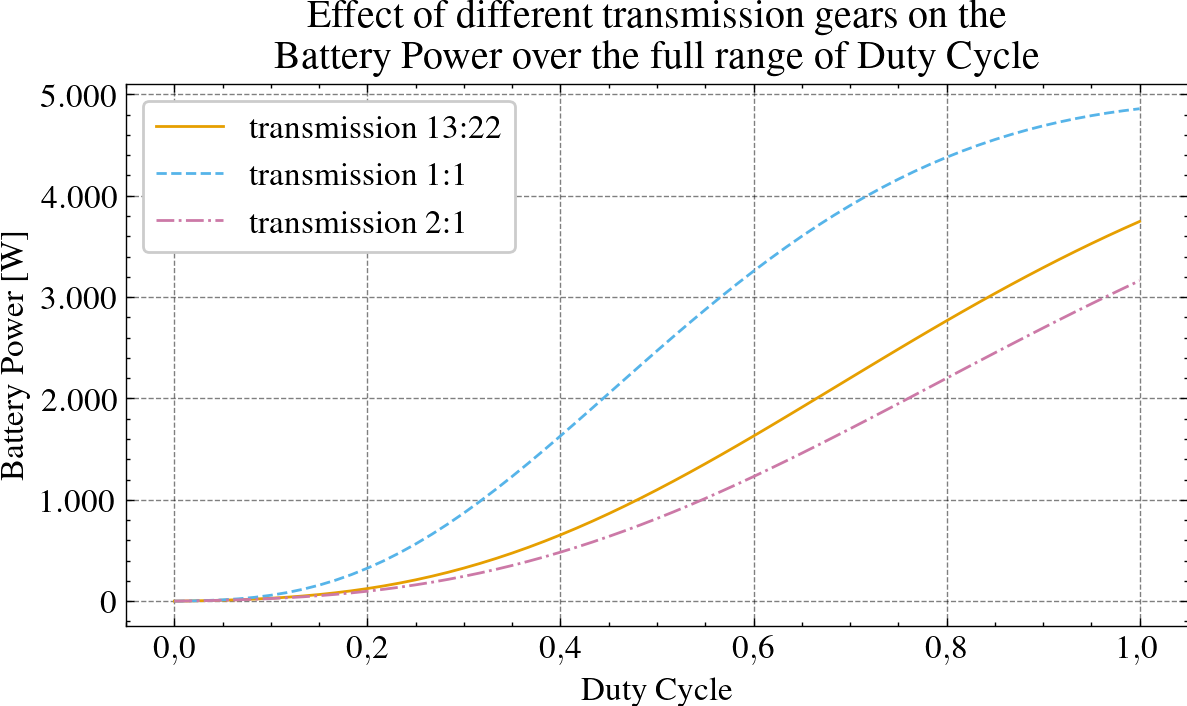

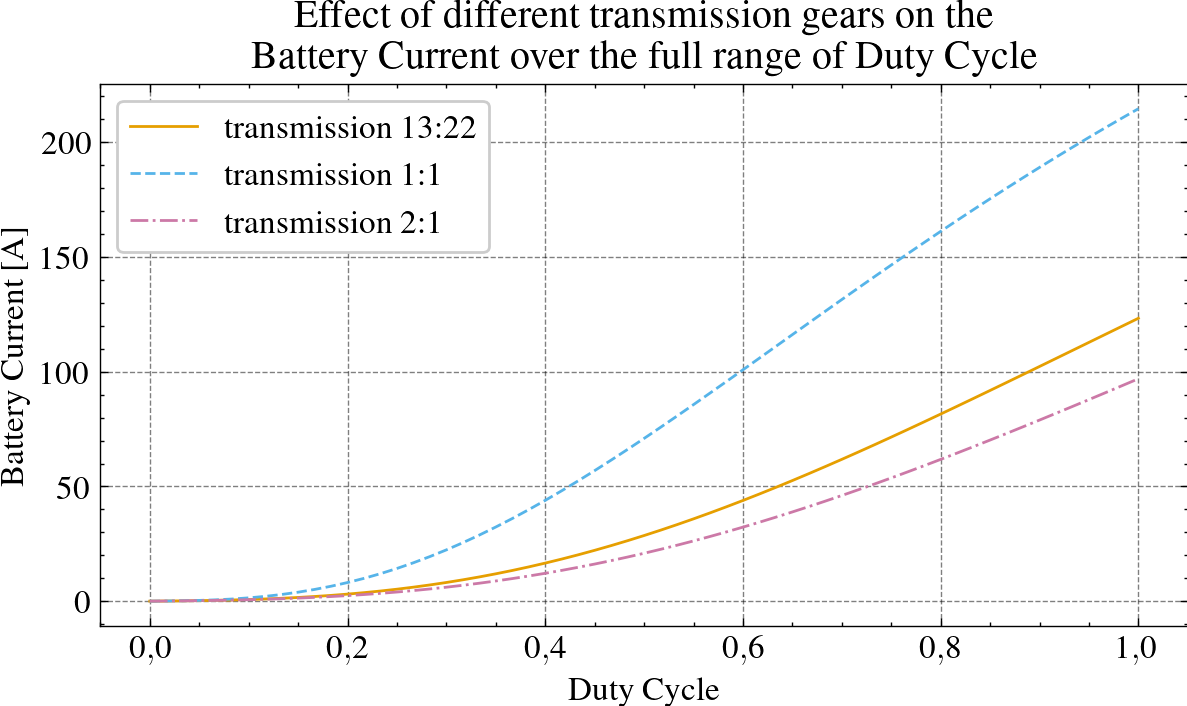

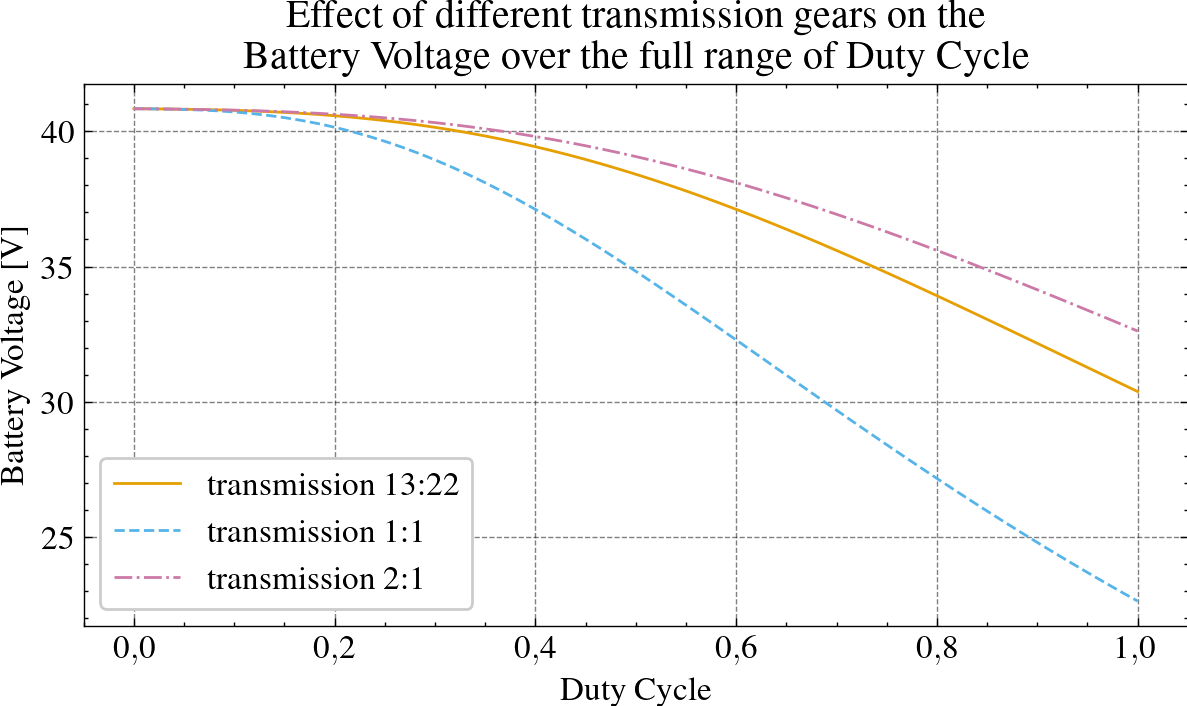

In [105]:
plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['bat_p'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['bat_p'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['bat_p'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Battery Power [W]")
plt.title("Effect of different transmission gears on the \nBattery Power over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['bat_i'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['bat_i'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['bat_i'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Battery Current [A]")
plt.title("Effect of different transmission gears on the \nBattery Current over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['bat_v'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['bat_v'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['bat_v'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Battery Voltage [V]")
plt.title("Effect of different transmission gears on the \nBattery Voltage over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()


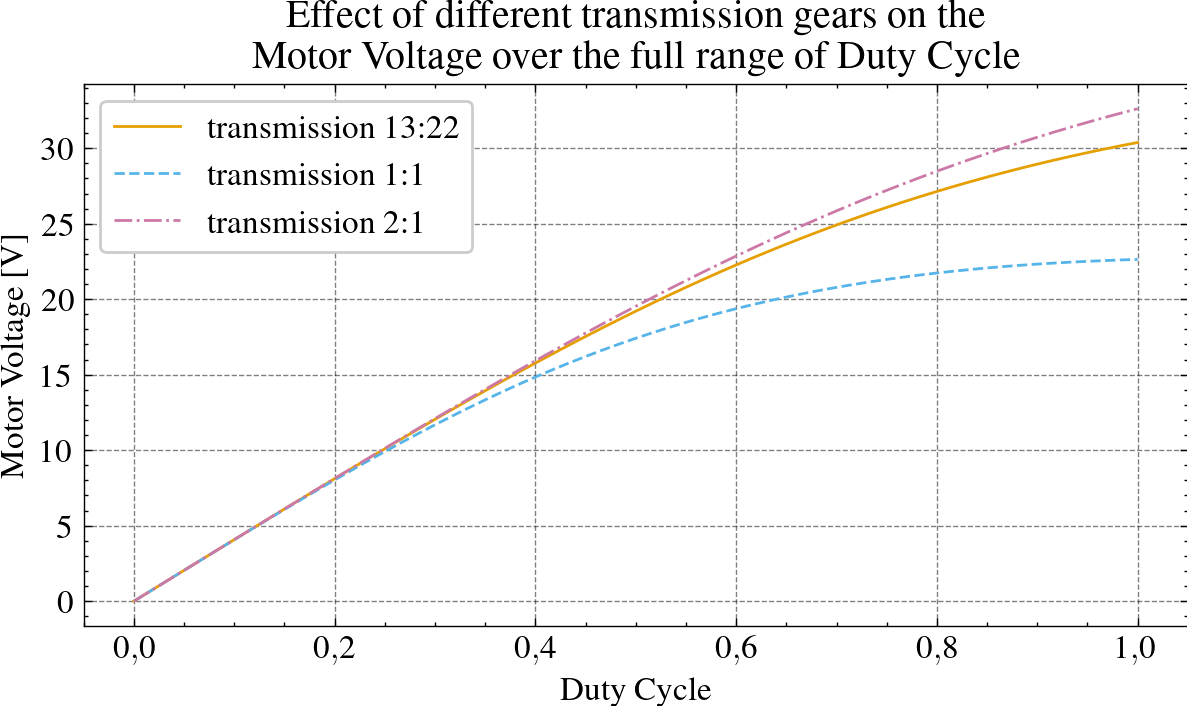

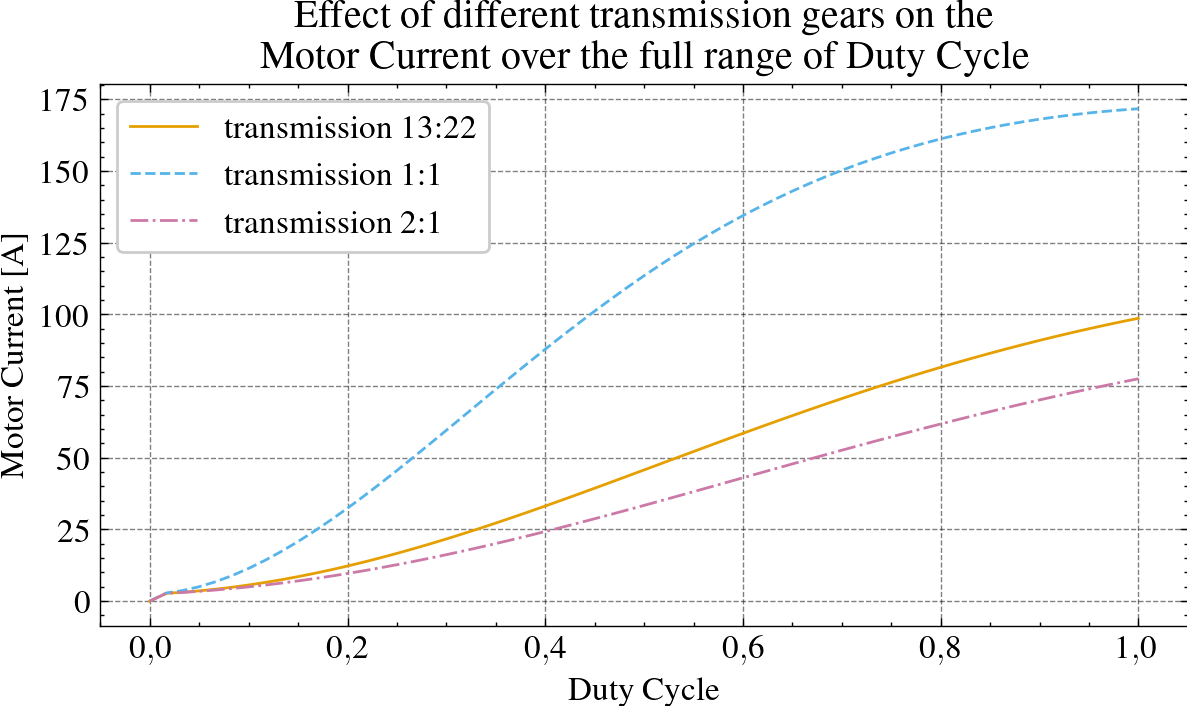

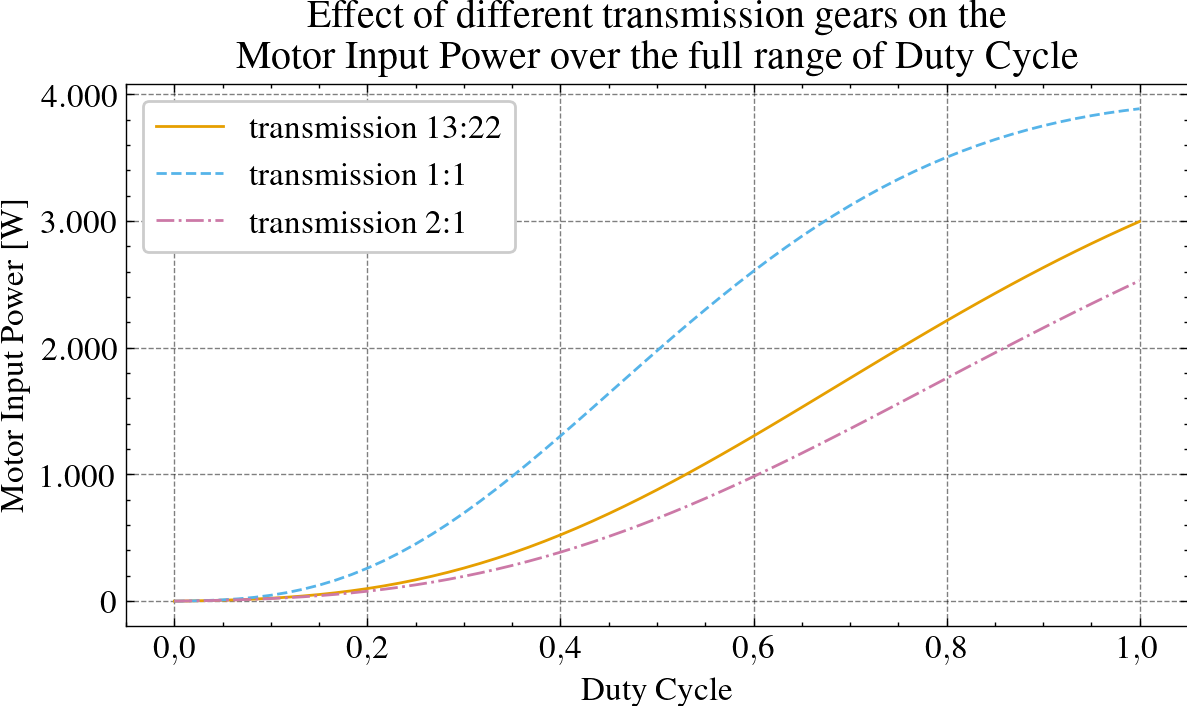

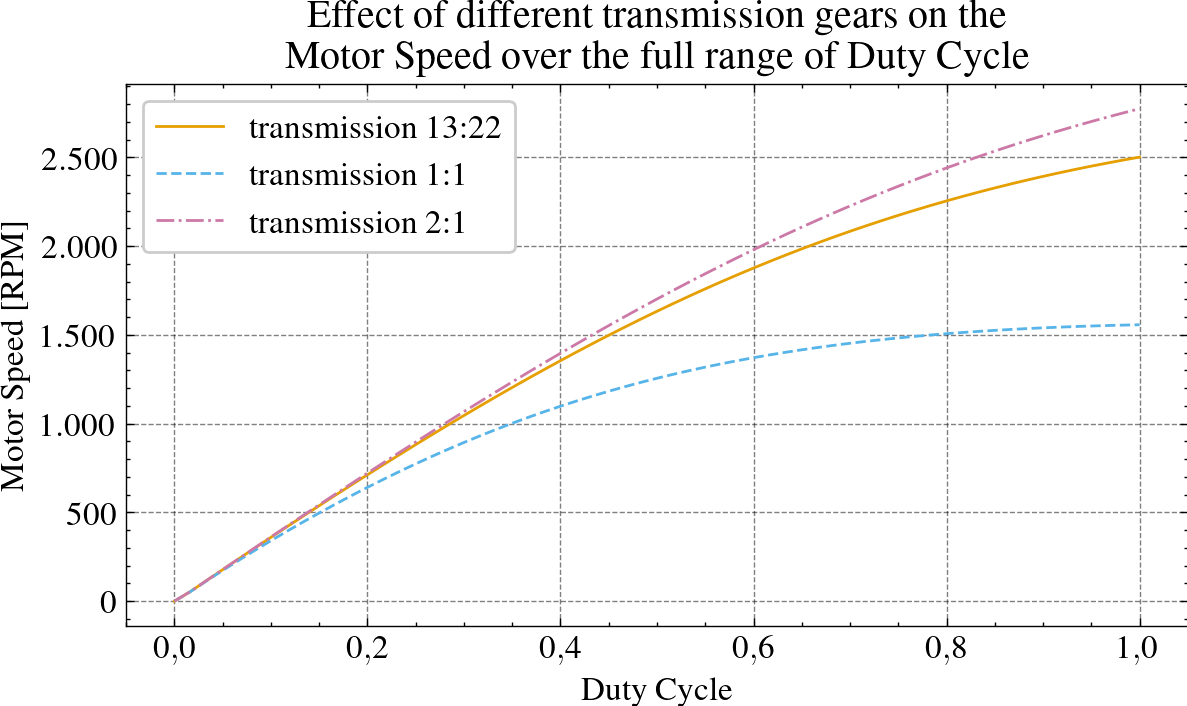

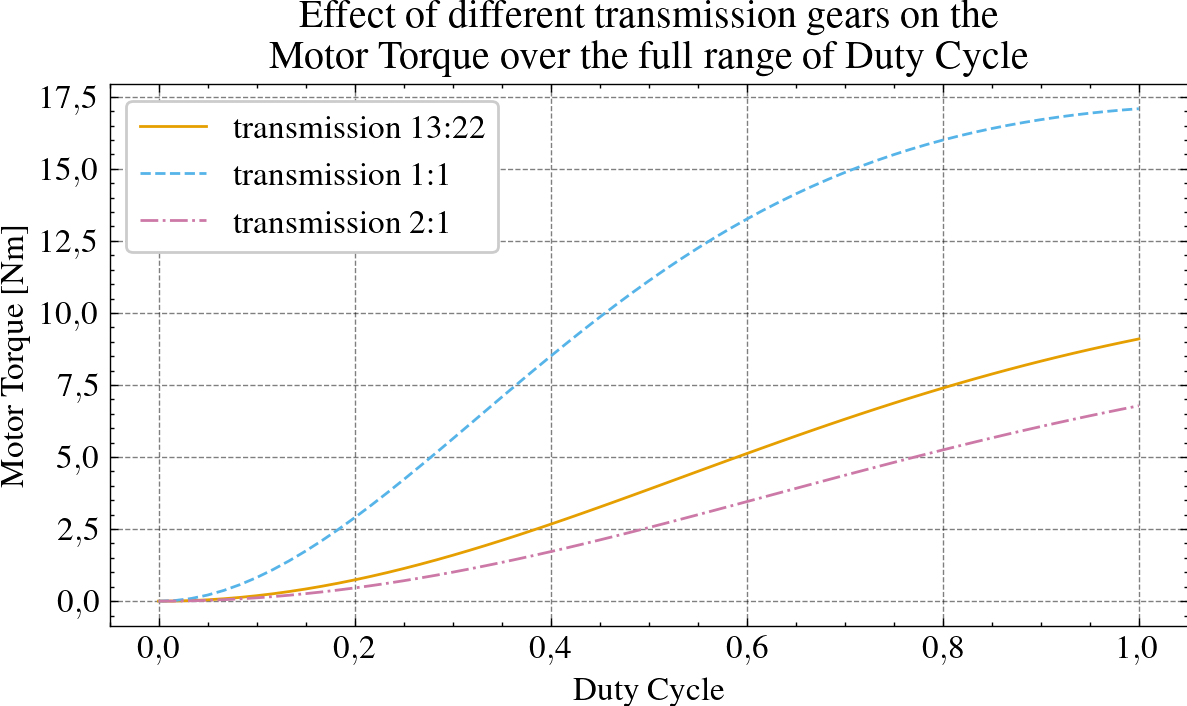

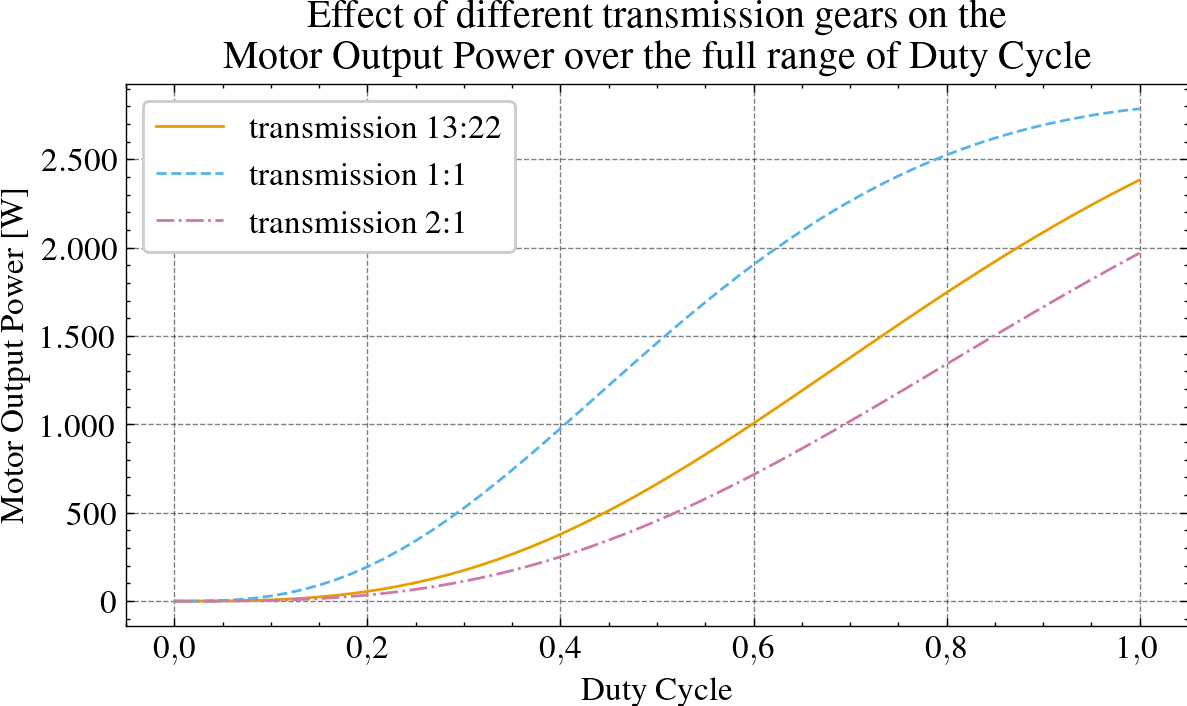

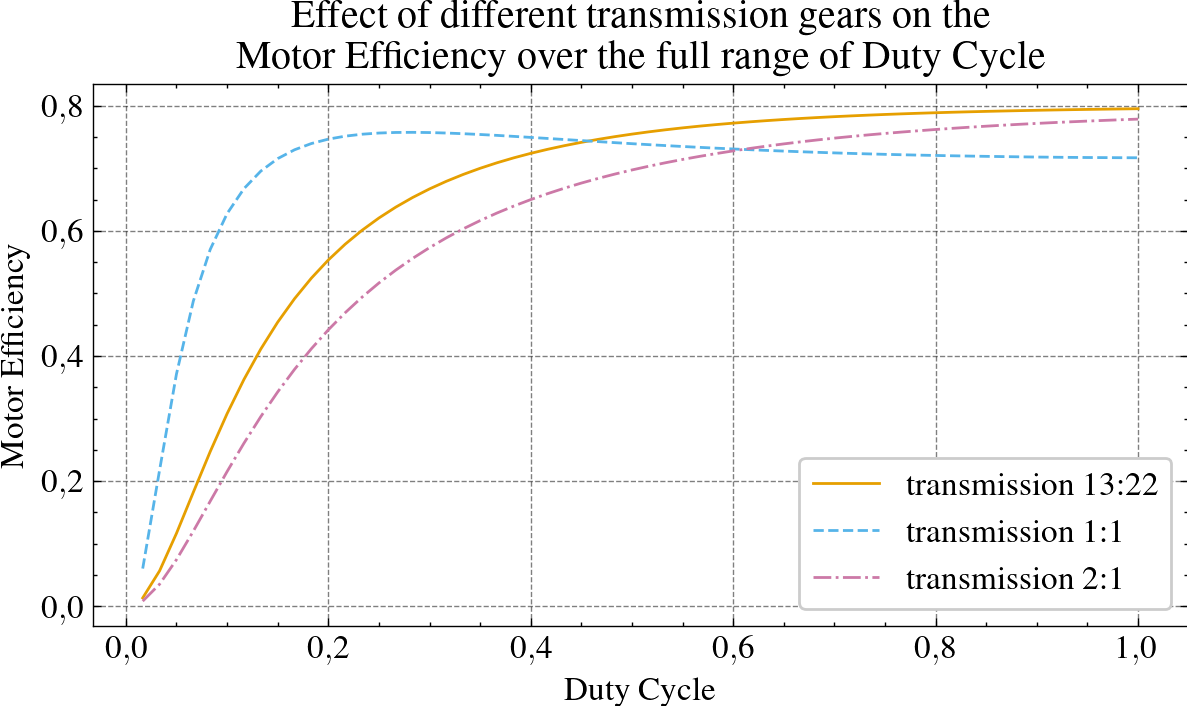

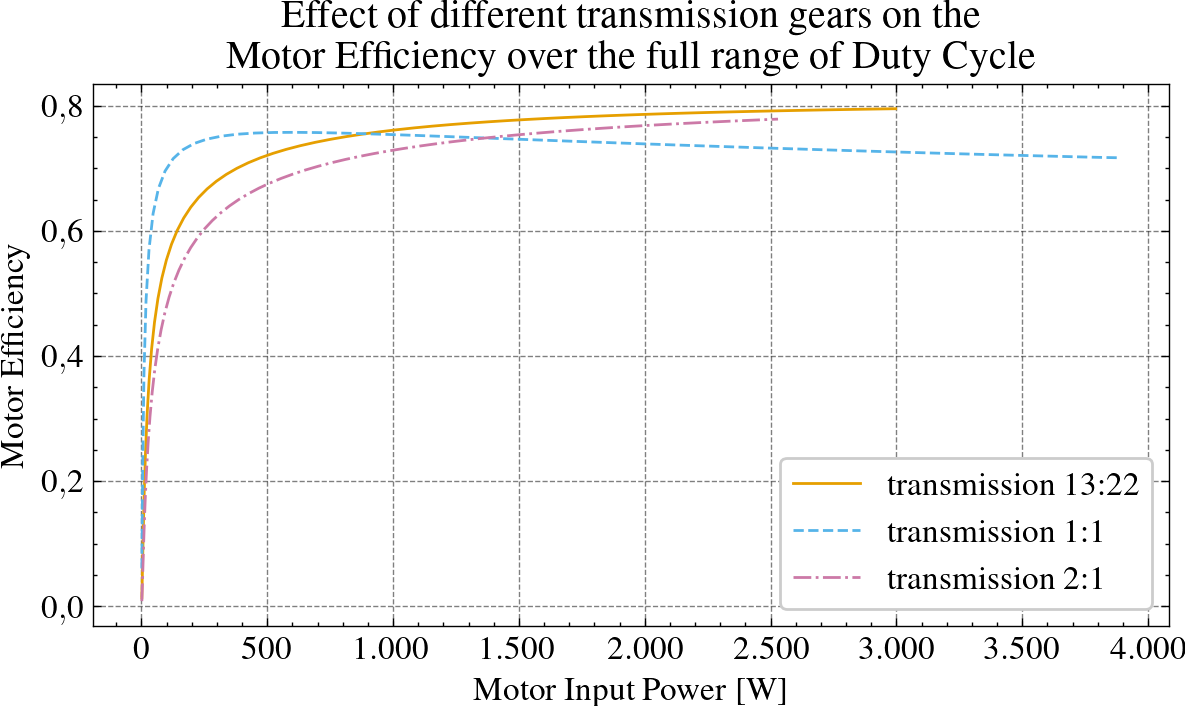

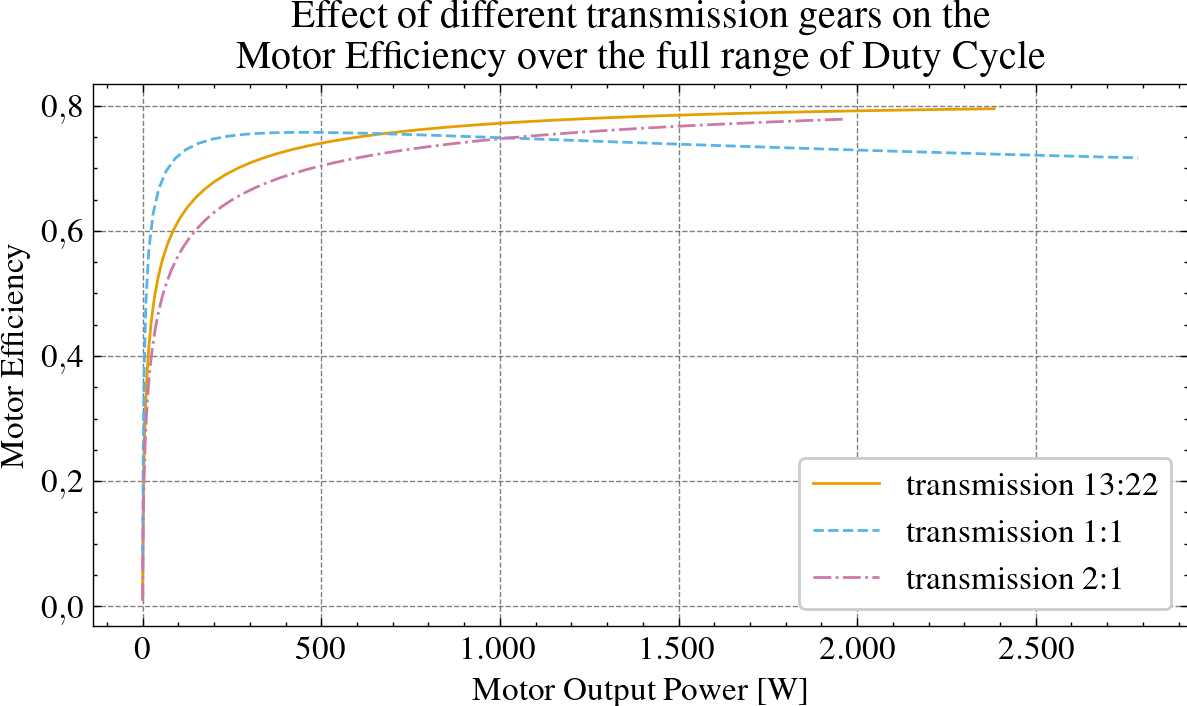

In [106]:
plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['motor_v'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['motor_v'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['motor_v'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Voltage [V]")
plt.title("Effect of different transmission gears on the \nMotor Voltage over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['motor_i'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['motor_i'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['motor_i'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Current [A]")
plt.title("Effect of different transmission gears on the \nMotor Current over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['motor_pi'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['motor_pi'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['motor_pi'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Input Power [W]")
plt.title("Effect of different transmission gears on the \nMotor Input Power over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['motor_w'] * 30 / np.pi, label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['motor_w'] * 30 / np.pi, label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['motor_w'] * 30 / np.pi, label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Speed [RPM]")
plt.title("Effect of different transmission gears on the \nMotor Speed over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['motor_q'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['motor_q'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['motor_q'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Torque [Nm]")
plt.title("Effect of different transmission gears on the \nMotor Torque over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['motor_po'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['motor_po'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['motor_po'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Output Power [W]")
plt.title("Effect of different transmission gears on the \nMotor Output Power over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['motor_eff'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['motor_eff'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['motor_eff'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Motor Efficiency")
plt.title("Effect of different transmission gears on the \nMotor Efficiency over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['motor_pi'], results_transmission_1['motor_eff'], label='transmission 13:22')
plt.plot(results_transmission_2['motor_pi'], results_transmission_2['motor_eff'], label='transmission 1:1')
plt.plot(results_transmission_3['motor_pi'], results_transmission_3['motor_eff'], label='transmission 2:1')
plt.xlabel("Motor Input Power [W]")
plt.ylabel("Motor Efficiency")
plt.title("Effect of different transmission gears on the \nMotor Efficiency over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['motor_po'], results_transmission_1['motor_eff'], label='transmission 13:22')
plt.plot(results_transmission_2['motor_po'], results_transmission_2['motor_eff'], label='transmission 1:1')
plt.plot(results_transmission_3['motor_po'], results_transmission_3['motor_eff'], label='transmission 2:1')
plt.xlabel("Motor Output Power [W]")
plt.ylabel("Motor Efficiency")
plt.title("Effect of different transmission gears on the \nMotor Efficiency over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

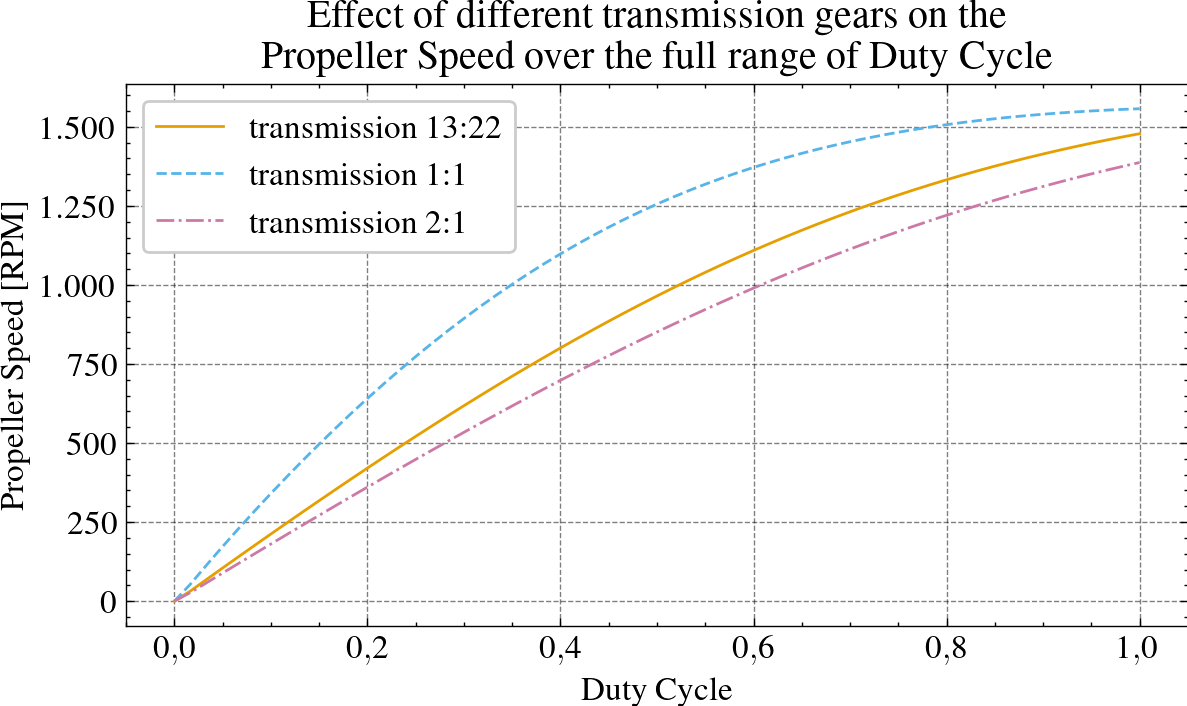

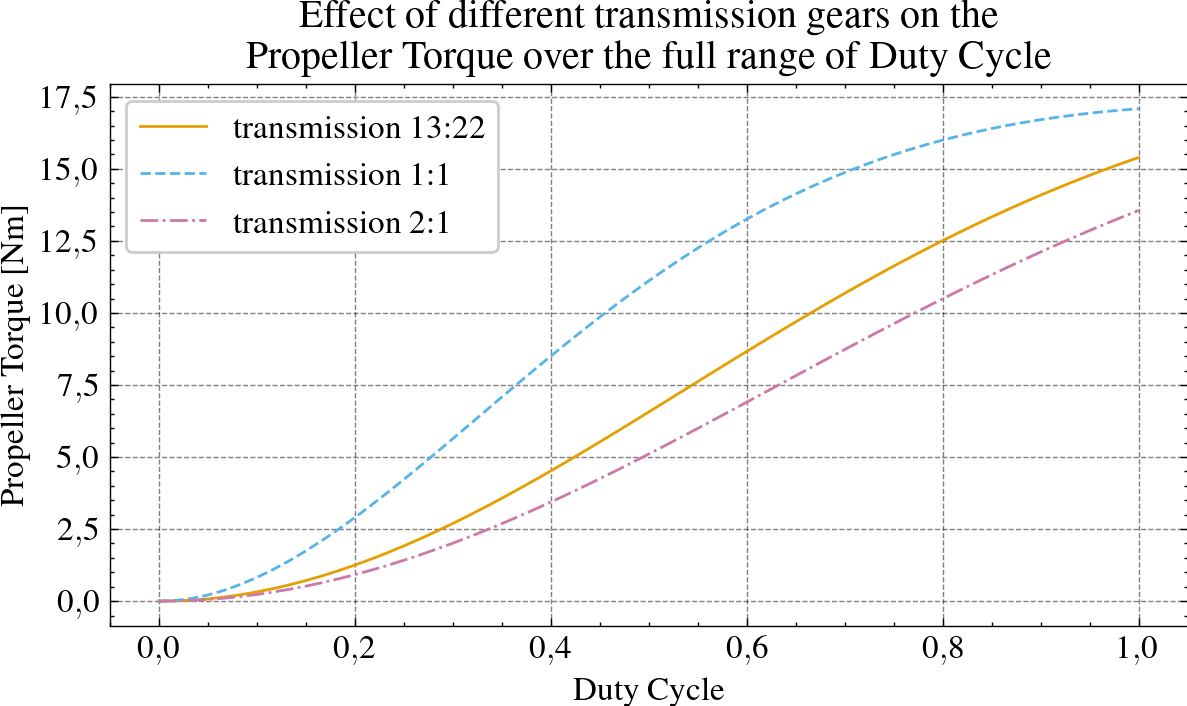

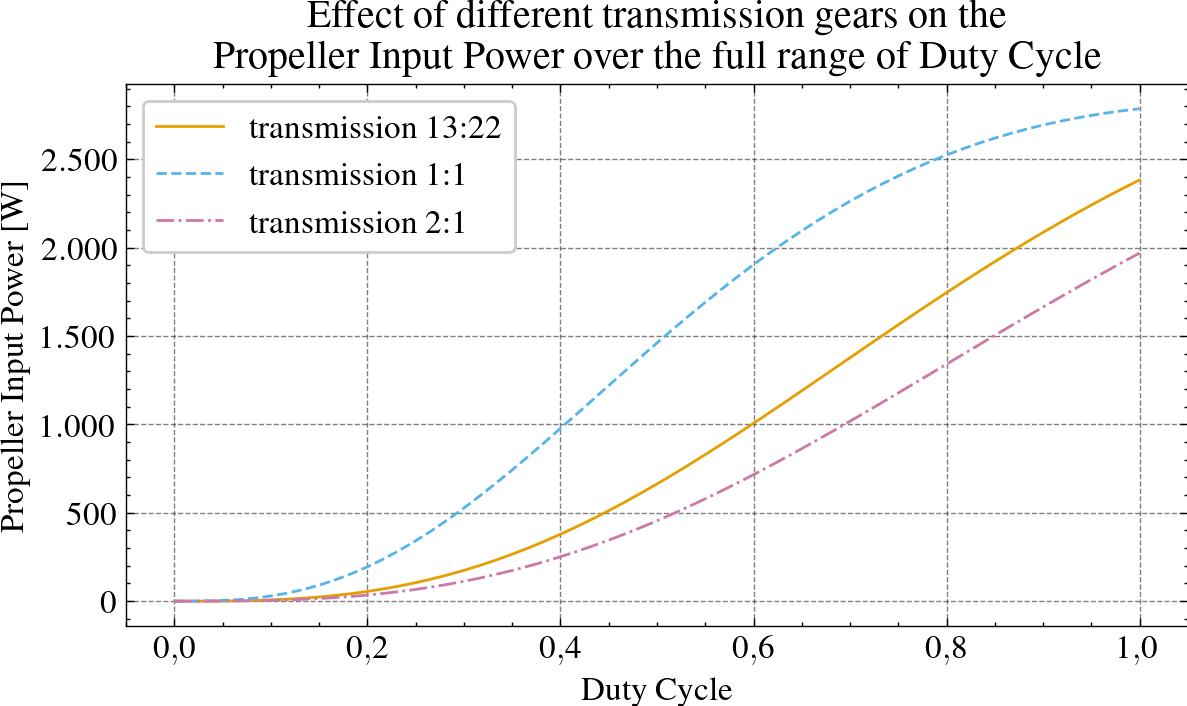

In [107]:
plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['prop_w'] * 30 / np.pi, label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['prop_w'] * 30 / np.pi, label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['prop_w'] * 30 / np.pi, label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Speed [RPM]")
plt.title("Effect of different transmission gears on the \nPropeller Speed over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['prop_q'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['prop_q'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['prop_q'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Torque [Nm]")
plt.title("Effect of different transmission gears on the \nPropeller Torque over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['prop_pi'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['prop_pi'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['prop_pi'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Input Power [W]")
plt.title("Effect of different transmission gears on the \nPropeller Input Power over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

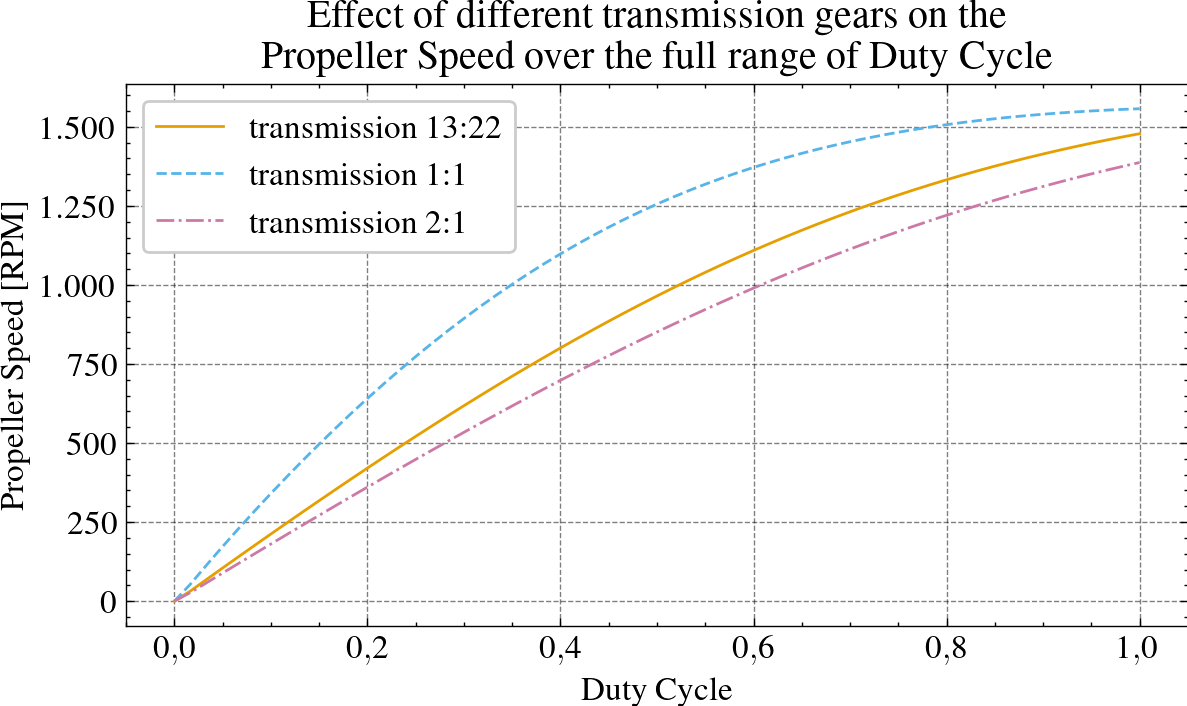

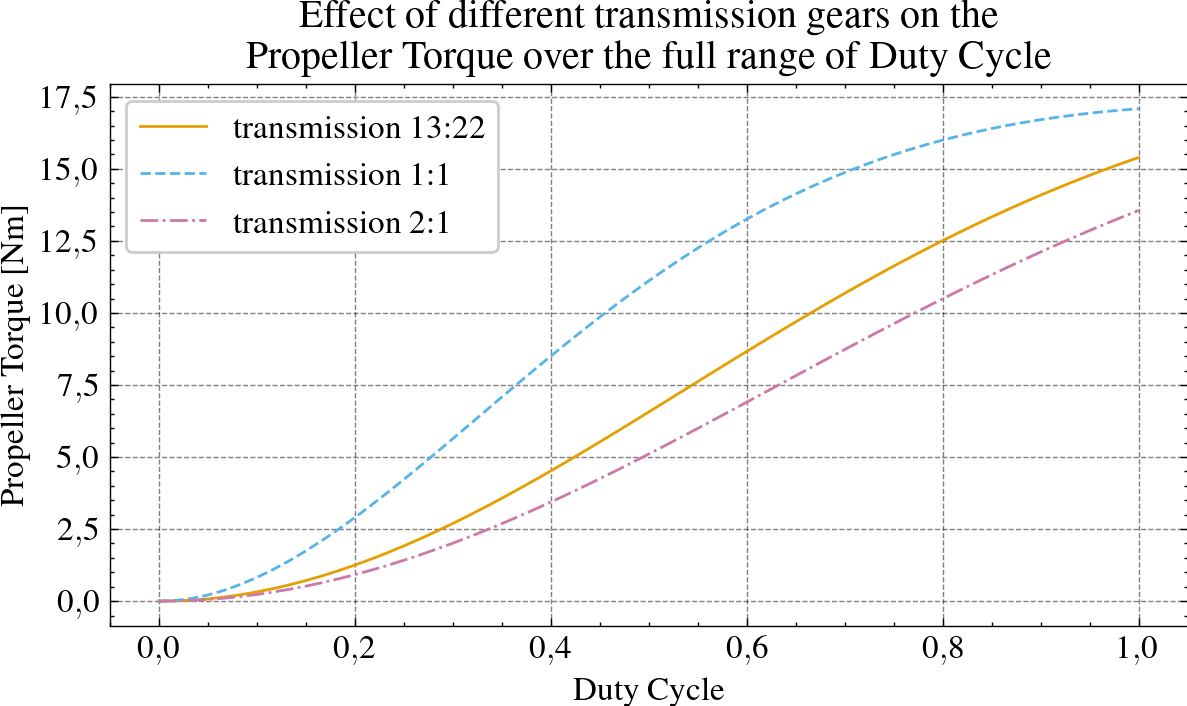

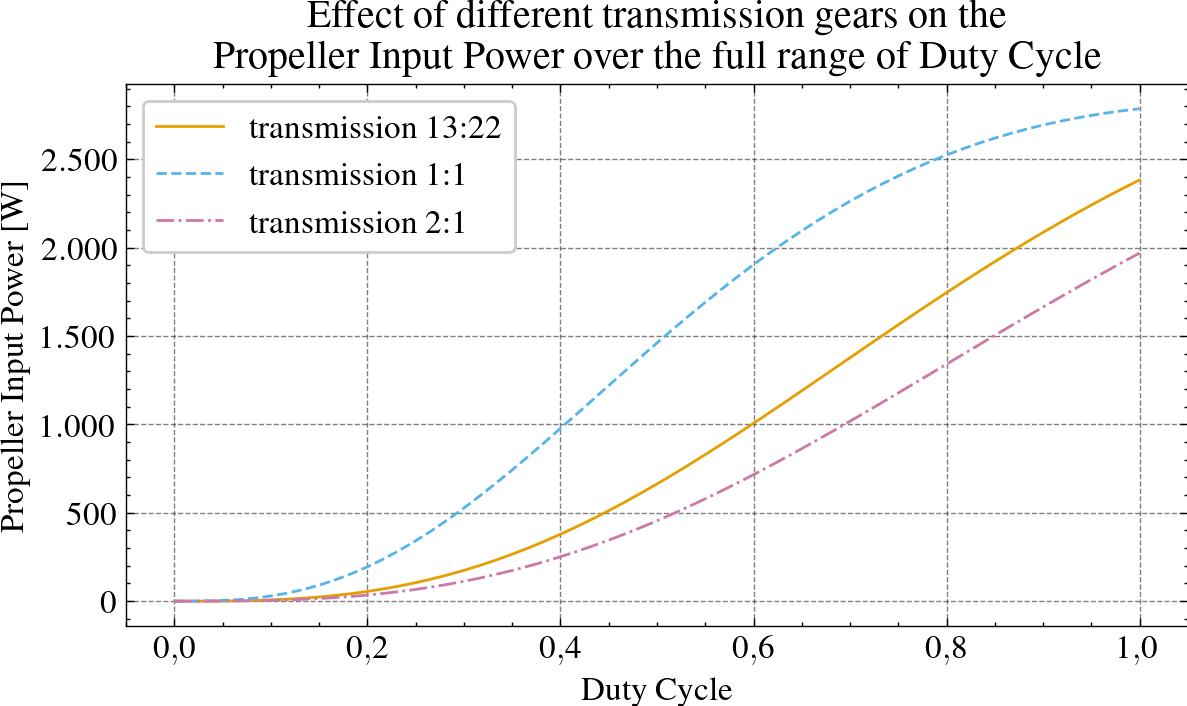

In [108]:
plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['prop_w'] * 30 / np.pi, label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['prop_w'] * 30 / np.pi, label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['prop_w'] * 30 / np.pi, label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Speed [RPM]")
plt.title("Effect of different transmission gears on the \nPropeller Speed over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['prop_q'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['prop_q'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['prop_q'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Torque [Nm]")
plt.title("Effect of different transmission gears on the \nPropeller Torque over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['prop_pi'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['prop_pi'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['prop_pi'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propeller Input Power [W]")
plt.title("Effect of different transmission gears on the \nPropeller Input Power over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

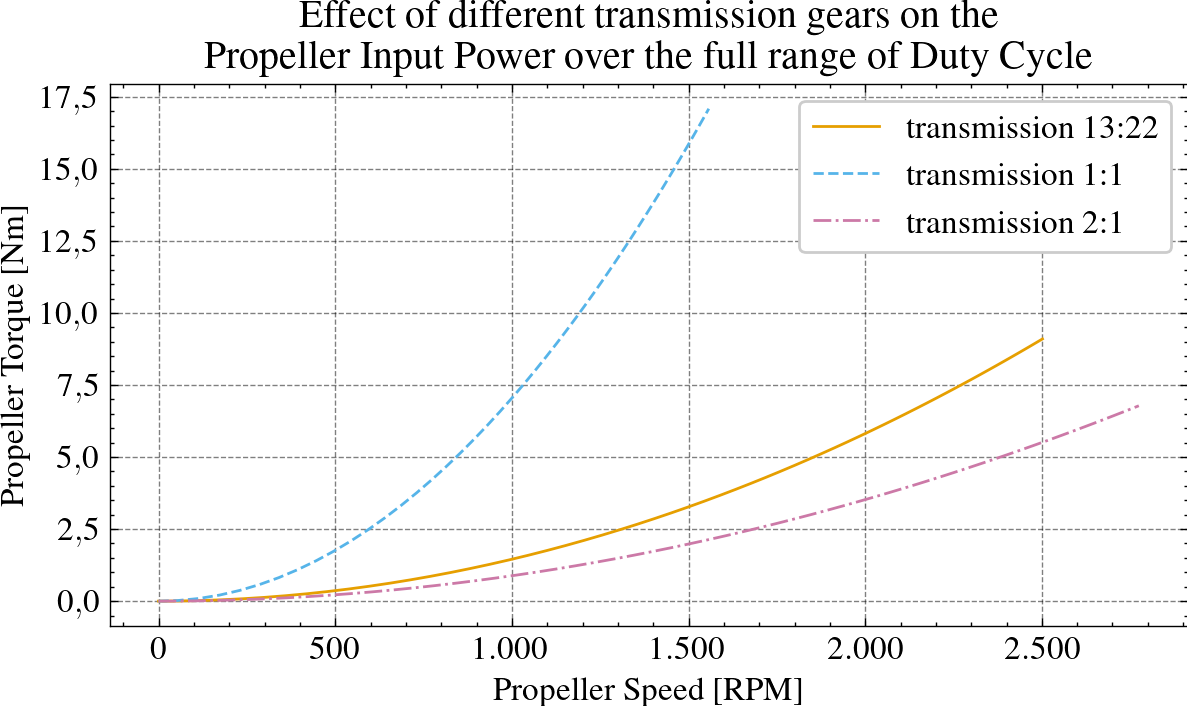

In [109]:
plt.figure()
plt.plot(results_transmission_1['motor_w'] * 30 / np.pi, results_transmission_1['motor_q'], label='transmission 13:22')
plt.plot(results_transmission_2['motor_w'] * 30 / np.pi, results_transmission_2['motor_q'], label='transmission 1:1')
plt.plot(results_transmission_3['motor_w'] * 30 / np.pi, results_transmission_3['motor_q'], label='transmission 2:1')
plt.xlabel("Propeller Speed [RPM]")
plt.ylabel("Propeller Torque [Nm]")
plt.title("Effect of different transmission gears on the \nPropeller Input Power over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()

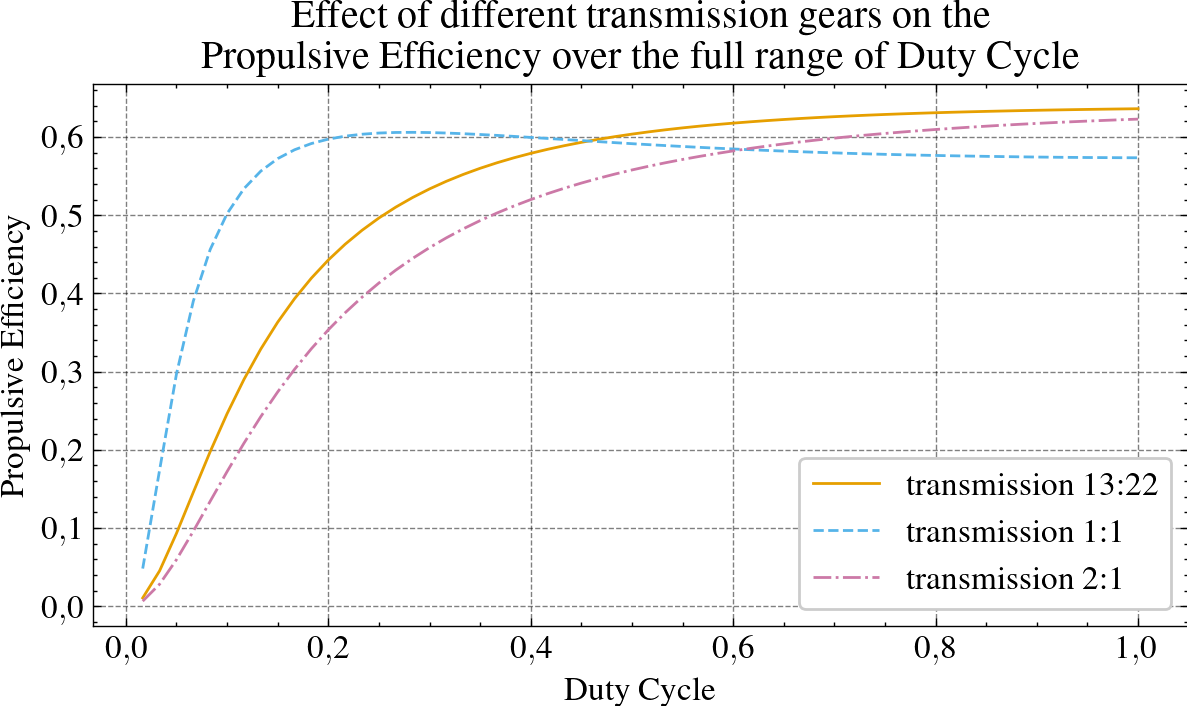

In [110]:
plt.figure()
plt.plot(results_transmission_1['D'], results_transmission_1['prop_pi'] / results_transmission_1['bat_p'], label='transmission 13:22')
plt.plot(results_transmission_2['D'], results_transmission_2['prop_pi'] / results_transmission_2['bat_p'], label='transmission 1:1')
plt.plot(results_transmission_3['D'], results_transmission_3['prop_pi'] / results_transmission_3['bat_p'], label='transmission 2:1')
plt.xlabel("Duty Cycle")
plt.ylabel("Propulsive Efficiency")
plt.title("Effect of different transmission gears on the \nPropulsive Efficiency over the full range of Duty Cycle")
plt.legend()
plt.tight_layout()
plt.show()